
 Synthetic DA configuration summary
 Grid size              : nx = 120, nz = 50
 Domain size            : Lx = 100.0 km, Lz = 15.0 km
 Observation columns    : 7
 Points per column      : 20
 Total observations     : 140
 Horizontal indices     : [7, 24, 42, 60, 77, 95, 113]
 Vertical indices       : [0, 2, 5, 7, 10, 12, 15, 18, 20, 23, 25, 28, 30, 33, 36, 38, 41, 43, 46, 49]



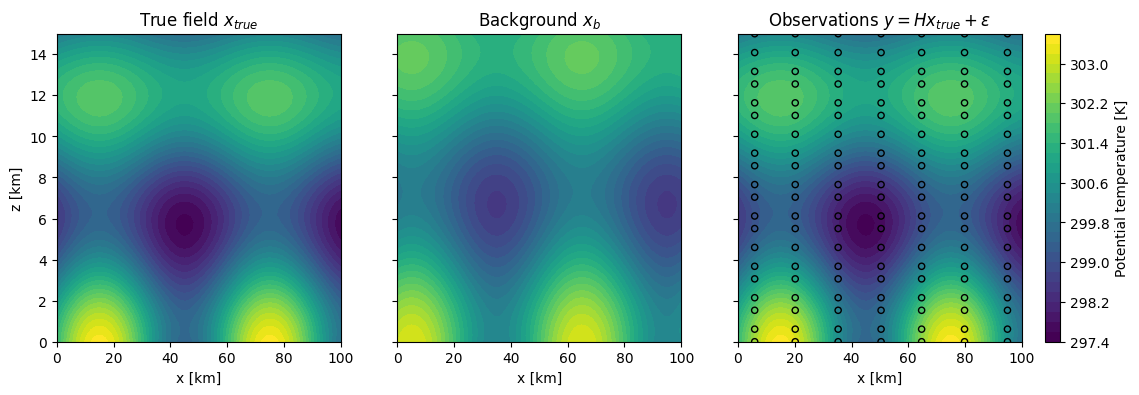

In [16]:
# ============================================================
# Demo 2D atmospheric field + observations + background
# One self-contained Jupyter cell
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

np.random.seed(42)  # reproducibility

# ---------------------------
# 1. Grid definition
# ---------------------------
nx = 120          # horizontal points (~100 km)
nz = 50           # vertical levels
Lx_km = 100.0
Lz_km = 15.0

x_km = np.linspace(0, Lx_km, nx)
z_km = np.linspace(0, Lz_km, nz)
X, Z = np.meshgrid(x_km, z_km)

# ---------------------------
# 2. True atmospheric field xtrue
# ---------------------------
theta0 = 300.0

xtrue = (
    theta0
    + 2.0 * np.sin(2 * np.pi * X / 60.0) * np.exp(-Z / 8.0)
    + 1.5 * np.cos(2 * np.pi * Z / 12.0)
)

# ---------------------------
# 3. Background field xb
# ---------------------------
xb = (
    theta0
    + 1.5 * np.sin(2 * np.pi * (X + 10.0) / 60.0) * np.exp(-Z / 10.0)
    + 1.2 * np.cos(2 * np.pi * Z / 14.0)
    + 0.5
)

# ---------------------------
# 4. Observation operator H
# (3 columns, 10 vertical points each)
# ---------------------------
n_obs_x = 7          # number of columns
n_obs_z = 20         # points per column
obs_err_true = 0.01  # true observation error

obs_x_idx = np.linspace(n_obs_x, nx - n_obs_x, n_obs_x, dtype=int)
obs_z_idx = np.linspace(0, nz - 1, n_obs_z, dtype=int)

# observation list: (ix, iz, value)
y = []

# sparse 2D observation field (NaN elsewhere)
y_field = np.full_like(xtrue, np.nan)

for ix in obs_x_idx:
    for iz in obs_z_idx:
        val = xtrue[iz, ix] + obs_err_true * np.random.randn()
        y.append((ix, iz, val))
        y_field[iz, ix] = val

# ---------------------------
# 4b. Formatted DA summary
# ---------------------------
print("\n" + "=" * 55)
print(" Synthetic DA configuration summary")
print("=" * 55)
print(f" Grid size              : nx = {nx}, nz = {nz}")
print(f" Domain size            : Lx = {Lx_km:.1f} km, Lz = {Lz_km:.1f} km")
print(f" Observation columns    : {n_obs_x}")
print(f" Points per column      : {n_obs_z}")
print(f" Total observations     : {len(y)}")
print(f" Horizontal indices     : {obs_x_idx.tolist()}")
print(f" Vertical indices       : {obs_z_idx.tolist()}")
print("=" * 55 + "\n")

# ---------------------------
# 5. Plotting
# ---------------------------
vmin = min(xtrue.min(), xb.min())
vmax = max(xtrue.max(), xb.max())
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# --- True field ---
cf0 = axs[0].contourf(X, Z, xtrue, levels=30, cmap="viridis", norm=norm)
axs[0].set_title("True field $x_{true}$")
axs[0].set_xlabel("x [km]")
axs[0].set_ylabel("z [km]")

# --- Background field ---
cf1 = axs[1].contourf(X, Z, xb, levels=30, cmap="viridis", norm=norm)
axs[1].set_title("Background $x_b$")
axs[1].set_xlabel("x [km]")

# --- Observations ---
cf2 = axs[2].contourf(X, Z, xtrue, levels=30, cmap="viridis", norm=norm)

x_obs = [x_km[ix] for ix, iz, _ in y]
z_obs = [z_km[iz] for ix, iz, _ in y]
y_obs = [val for _, _, val in y]

axs[2].scatter(
    x_obs,
    z_obs,
    c=y_obs,
    cmap="viridis",
    norm=norm,
    edgecolors="k",
    s=20,
)

axs[2].set_title("Observations $y = Hx_{true} + \\varepsilon$")
axs[2].set_xlabel("x [km]")

# Colorbar
cbar = fig.colorbar(cf0, ax=axs, pad=0.02)
cbar.set_label("Potential temperature [K]")

plt.savefig("2d_setup.png")
plt.show()



 Gaussian B operator
 Correlation lengths : Lx = 25.0 km, Lz = 2.0 km
 Impulse index       : ix = 60, iz = 25
 max(B e_ij)         : 1.000e+00



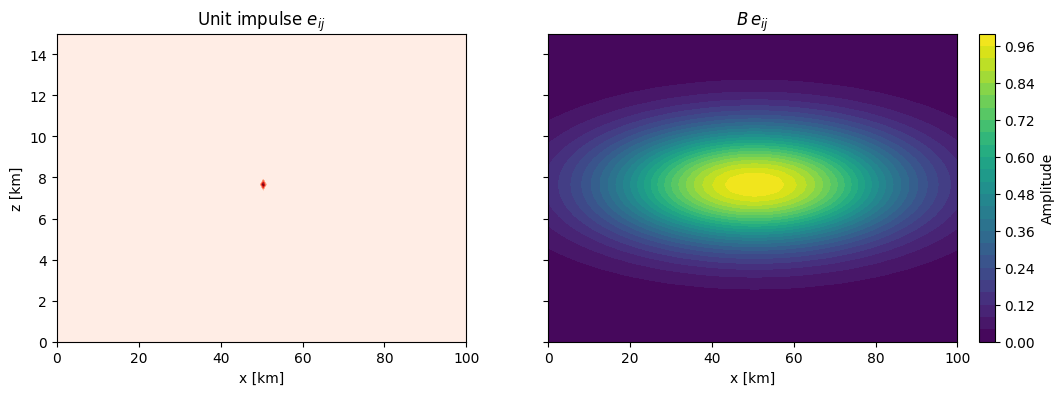

In [2]:
# ============================================================
# Cell 2: Gaussian background-error covariance B
# Define B and apply it to a unit impulse e_ij
# ============================================================

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

# ---------------------------
# 1. B-parameters (same grid as Cell 1)
# ---------------------------
Lx = 25.0      # horizontal correlation length [km]
Lz = 2.0       # vertical correlation length [km]
sigma_b = 1.0  # background std dev

# ---------------------------
# 2. Gaussian correlation matrices
# ---------------------------
def gaussian_corr(coords, L):
    D2 = (coords[:, None] - coords[None, :])**2
    return np.exp(-0.5 * D2 / (L**2))

Kx = gaussian_corr(x_km, Lx)   # (nx, nx)
Kz = gaussian_corr(z_km, Lz)   # (nz, nz)

lam_x, Ux = np.linalg.eigh(Kx)
lam_z, Uz = np.linalg.eigh(Kz)

# ---------------------------
# 3. B operator
# ---------------------------
def B_apply(R):
    """
    Apply Gaussian background-error covariance B.
    R shape: (nz, nx)
    """
    Rt = Uz.T @ R @ Ux
    Bt = sigma_b**2 * Rt * (lam_z[:, None] * lam_x[None, :])
    return Uz @ Bt @ Ux.T

# ---------------------------
# 4. Unit impulse e_ij
# ---------------------------
ix0 = nx // 2
iz0 = nz // 2

e = np.zeros((nz, nx))
e[iz0, ix0] = 1.0

Be = B_apply(e)

# ---------------------------
# 5. Diagnostics
# ---------------------------
print("\n" + "=" * 55)
print(" Gaussian B operator")
print("=" * 55)
print(f" Correlation lengths : Lx = {Lx} km, Lz = {Lz} km")
print(f" Impulse index       : ix = {ix0}, iz = {iz0}")
print(f" max(B e_ij)         : {Be.max():.3e}")
print("=" * 55 + "\n")

# ---------------------------
# 6. Plotting
# ---------------------------
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

axs[0].contourf(X, Z, e, levels=10, cmap="Reds")
axs[0].set_title(r"Unit impulse $e_{ij}$")
axs[0].set_xlabel("x [km]")
axs[0].set_ylabel("z [km]")

norm = Normalize(vmin=0.0, vmax=Be.max())
cf = axs[1].contourf(X, Z, Be, levels=30, cmap="viridis", norm=norm)
axs[1].set_title(r"$B\,e_{ij}$")
axs[1].set_xlabel("x [km]")

cbar = fig.colorbar(cf, ax=axs, pad=0.02)
cbar.set_label("Amplitude")

plt.show()



 B^{-1} reconstruction test
 max(e)            : 1.000e+00
 max(B e)          : 1.000e+00
 max(B^-1 B e)   : 1.841e-02
 L2 error          : 9.903e-01



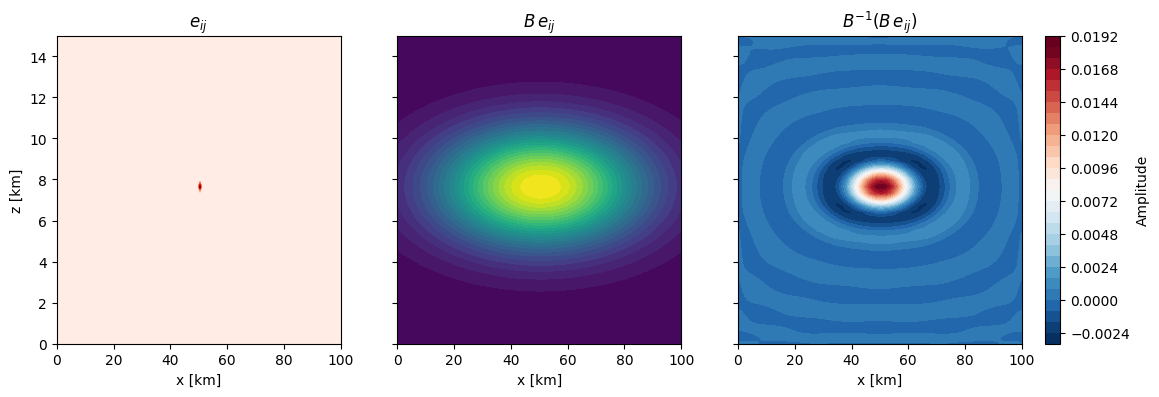

In [3]:
# ============================================================
# Cell 3: Regularized inverse B^{-1} and reconstruction test
# ============================================================

# ---------------------------
# 1. Regularization
# ---------------------------
eps = 1e-6 #1e-3 * sigma_b**2

den = sigma_b**2 * (lam_z[:, None] * lam_x[None, :]) + eps

# ---------------------------
# 2. Regularized inverse operator
# ---------------------------
def Binv_apply(R):
    """
    Apply regularized inverse (B + eps I)^(-1).
    R shape: (nz, nx)
    """
    Rt = Uz.T @ R @ Ux
    Xt = Rt / den
    return Uz @ Xt @ Ux.T

# ---------------------------
# 3. Reconstruction
# ---------------------------
e_rec = Binv_apply(Be)

# ---------------------------
# 4. Diagnostics
# ---------------------------
print("\n" + "=" * 60)
print(" B^{-1} reconstruction test")
print("=" * 60)
print(f" max(e)            : {e.max():.3e}")
print(f" max(B e)          : {Be.max():.3e}")
print(f" max(B^{-1} B e)   : {e_rec.max():.3e}")
print(f" L2 error          : {np.linalg.norm(e - e_rec):.3e}")
print("=" * 60 + "\n")

# ---------------------------
# 5. Plotting
# ---------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axs[0].contourf(X, Z, e, levels=10, cmap="Reds")
axs[0].set_title(r"$e_{ij}$")
axs[0].set_xlabel("x [km]")
axs[0].set_ylabel("z [km]")

norm_be = Normalize(vmin=0.0, vmax=Be.max())
axs[1].contourf(X, Z, Be, levels=30, cmap="viridis", norm=norm_be)
axs[1].set_title(r"$B\,e_{ij}$")
axs[1].set_xlabel("x [km]")

norm_rec = Normalize(vmin=e_rec.min(), vmax=e_rec.max())
cf = axs[2].contourf(X, Z, e_rec, levels=30, cmap="RdBu_r", norm=norm_rec)
axs[2].set_title(r"$B^{-1}(B\,e_{ij})$")
axs[2].set_xlabel("x [km]")

cbar = fig.colorbar(cf, ax=axs, pad=0.02)
cbar.set_label("Amplitude")

plt.show()


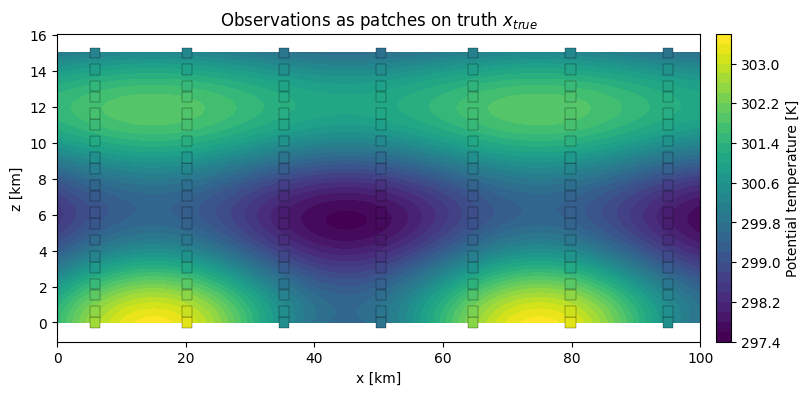

In [17]:
# ============================================================
# Sanity check: plot observations as patches on top of truth
# ============================================================

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
import numpy as np

# ------------------------------------------------------------
# Normalization (use truth only)
# ------------------------------------------------------------
norm = Normalize(vmin=xtrue.min(), vmax=xtrue.max())

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# --- Truth field ---
cf = ax.contourf(X, Z, xtrue, levels=30, cmap="viridis", norm=norm)

# ------------------------------------------------------------
# Observation patch size (in physical units)
# ------------------------------------------------------------
dx_patch = (x_km[1] - x_km[0]) * 1.9
dz_patch = (z_km[1] - z_km[0]) * 1.9

# ------------------------------------------------------------
# Draw observation patches
# ------------------------------------------------------------
for ix, iz, val in y:
    rect = Rectangle(
        (x_km[ix] - dx_patch / 2, z_km[iz] - dz_patch / 2),
        dx_patch,
        dz_patch,
        facecolor=plt.cm.viridis(norm(val)),
        edgecolor="k",
        linewidth=0.2,
        zorder=10
    )
    ax.add_patch(rect)

# ------------------------------------------------------------
# Labels and colorbar
# ------------------------------------------------------------
ax.set_title("Observations as patches on truth $x_{true}$")
ax.set_xlabel("x [km]")
ax.set_ylabel("z [km]")

cbar = fig.colorbar(cf, ax=ax, pad=0.02)
cbar.set_label("Potential temperature [K]")

plt.savefig("2d_obs_comp.png")
plt.show()


In [5]:
# ============================================================
# Cell 4: One-shot 3D-Var analysis (linear, explicit solve)
# ============================================================

# ---------------------------
# 1. Observation error
# ---------------------------
sigma_o = 0.01
Rinv = 1.0 / sigma_o**2

# ---------------------------
# 2. H and H^T operators
# ---------------------------
def H_apply(x):
    """Extract observations from state x -> vector y"""
    vals = []
    for ix in obs_x_idx:
        for iz in obs_z_idx:
            vals.append(x[iz, ix])
    return np.array(vals)

def HT_apply(z):
    """Map observation-space vector z back to state space"""
    v = np.zeros((nz, nx))
    k = 0
    for ix in obs_x_idx:
        for iz in obs_z_idx:
            v[iz, ix] += z[k]
            k += 1
    return v

# observation vector y
y_vec = np.array([val for _, _, val in y])

# ---------------------------
# 3. Right-hand side: B H^T R^{-1} (y - H xb)
# ---------------------------
d = y_vec - H_apply(xb)              # innovation
rhs = HT_apply(Rinv * d)

# ---------------------------
# 4. Linear operator A = B^{-1} + H^T R^{-1} H
# ---------------------------
def A_apply(x):
    term_b = Binv_apply(x)
    term_o = HT_apply(Rinv * H_apply(x))
    return term_b + term_o

# ---------------------------
# 5. Solve A dx = rhs (simple CG)
# ---------------------------
dx = np.zeros_like(xb)
r  = rhs - A_apply(dx)
p  = r.copy()

for it in range(500):
    Ap = A_apply(p)
    alpha = np.sum(r*r) / np.sum(p*Ap)
    dx += alpha * p
    r_new = r - alpha * Ap
    if np.linalg.norm(r_new) < 1e-5:
        break
    beta = np.sum(r_new*r_new) / np.sum(r*r)
    p = r_new + beta * p
    r = r_new

xa = xb + dx
xa_3dvar = xa # for later use and comparision

N = nx * nz

rmse_b = np.sqrt(np.mean((xb - xtrue)**2))
rmse_a = np.sqrt(np.mean((xa - xtrue)**2))
rmse_dx = np.sqrt(np.mean(dx**2))

print("\n" + "=" * 55)
print(" 3D-Var solve summary (RMSE)")
print("=" * 55)
print(f" Iterations        : {it+1}")
print(f" RMSE(dx)          : {rmse_dx:.3e}")
print(f" RMSE(x_b-x_true)  : {rmse_b:.3e}")
print(f" RMSE(x_a-x_true)  : {rmse_a:.3e}")
print("=" * 55 + "\n")




 3D-Var solve summary (RMSE)
 Iterations        : 500
 RMSE(dx)          : 8.950e-01
 RMSE(x_b-x_true)  : 8.923e-01
 RMSE(x_a-x_true)  : 1.713e-02



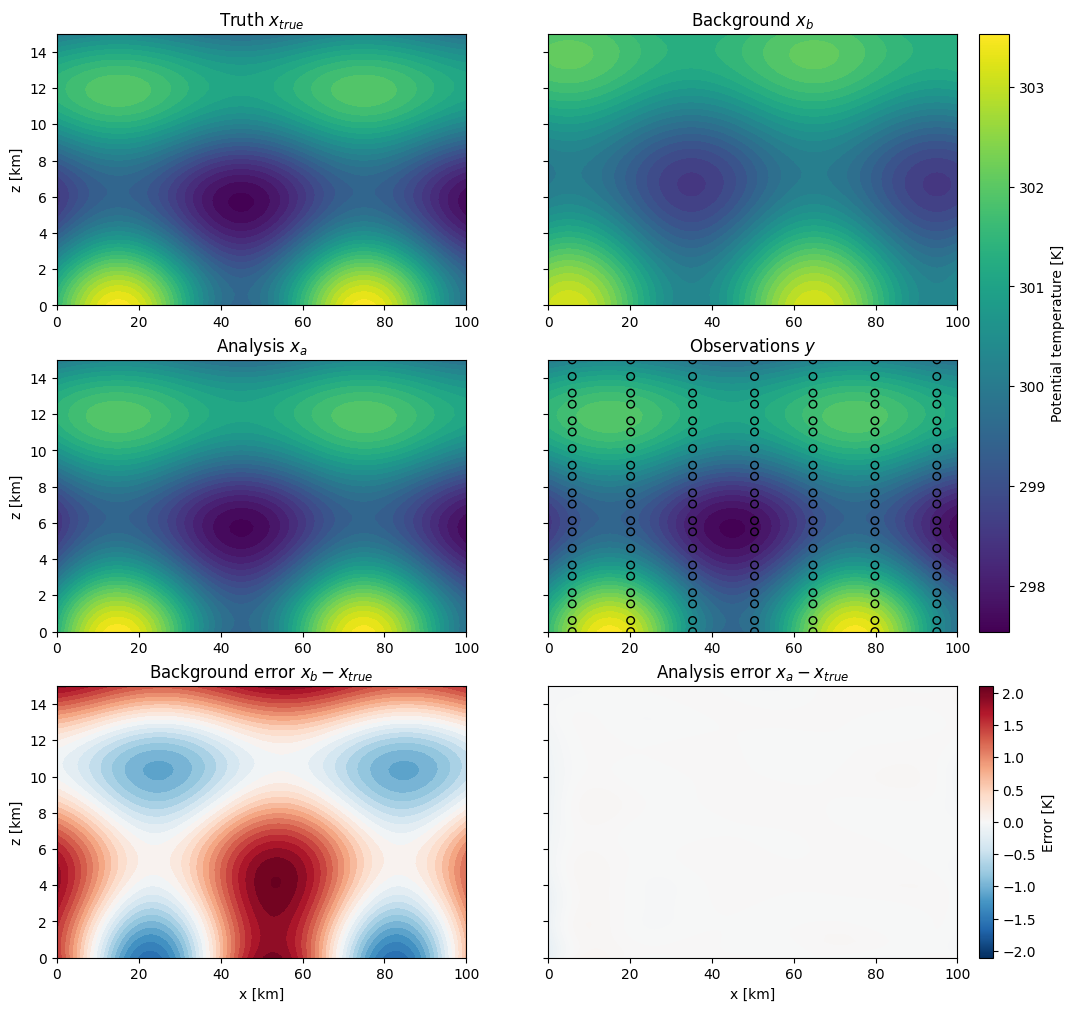

In [6]:
# ============================================================
# Plot truth, background, analysis, observations
# plus background and analysis errors
# ============================================================

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Global normalization for state fields
# ------------------------------------------------------------
vmin = min(xtrue.min(), xb.min(), xa.min())
vmax = max(xtrue.max(), xb.max(), xa.max())
norm_state = Normalize(vmin=vmin, vmax=vmax)

# ------------------------------------------------------------
# Error fields
# ------------------------------------------------------------
err_b = xb - xtrue
err_a = xa - xtrue

err_max = max(np.abs(err_b).max(), np.abs(err_a).max())
norm_err = Normalize(vmin=-err_max, vmax=err_max)

# ------------------------------------------------------------
# Figure layout: 3 rows × 2 columns
# ------------------------------------------------------------
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey=True)

# === Row 1: Truth & Background ===
axs[0,0].contourf(X, Z, xtrue, levels=30, cmap="viridis", norm=norm_state)
axs[0,0].set_title("Truth $x_{true}$")
axs[0,0].set_ylabel("z [km]")

axs[0,1].contourf(X, Z, xb, levels=30, cmap="viridis", norm=norm_state)
axs[0,1].set_title("Background $x_b$")

# === Row 2: Analysis & Observations ===
axs[1,0].contourf(X, Z, xa, levels=30, cmap="viridis", norm=norm_state)
axs[1,0].set_title("Analysis $x_a$")
axs[1,0].set_ylabel("z [km]")

axs[1,1].contourf(X, Z, xtrue, levels=30, cmap="viridis", norm=norm_state)

x_obs = [x_km[ix] for ix, iz, _ in y]
z_obs = [z_km[iz] for ix, iz, _ in y]
y_obs = [val for _, _, val in y]

axs[1,1].scatter(
    x_obs, z_obs,
    c=y_obs,
    cmap="viridis",
    norm=norm_state,
    edgecolors="k",
    s=30
)
axs[1,1].set_title("Observations $y$")

# === Row 3: Errors ===
axs[2,0].contourf(X, Z, err_b, levels=30, cmap="RdBu_r", norm=norm_err)
axs[2,0].set_title("Background error $x_b - x_{true}$")
axs[2,0].set_xlabel("x [km]")
axs[2,0].set_ylabel("z [km]")

cf_err = axs[2,1].contourf(X, Z, err_a, levels=30, cmap="RdBu_r", norm=norm_err)
axs[2,1].set_title("Analysis error $x_a - x_{true}$")
axs[2,1].set_xlabel("x [km]")

# ------------------------------------------------------------
# Colorbars
# ------------------------------------------------------------
cbar_state = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_state, cmap="viridis"),
    ax=axs[:2, :],
    pad=0.02
)
cbar_state.set_label("Potential temperature [K]")

cbar_err = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm_err, cmap="RdBu_r"),
    ax=axs[2, :],
    pad=0.02
)
cbar_err.set_label("Error [K]")

plt.show()


# ML AI-VAR Version

In [7]:
# ============================================================
# Cell 0: Build spectrally-regularized B^{-1} (2D → 1D control)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Control-space grid (flattened 2D)
# -------------------------------------------------
nz, nx = xb.shape
n = nz * nx

# physical coordinates (km)
X_flat = X.reshape(-1)
Z_flat = Z.reshape(-1)

# -------------------------------------------------
# USER PARAMETERS
# -------------------------------------------------
sigma_b = 1           # background std dev
Lx = 25.0             # horizontal correlation length [km]
Lz = 2.0              # vertical correlation length [km]
alpha = 1e-5          # relative eigenvalue floor (regularization)

# -------------------------------------------------
# Build Gaussian B (separable metric, full matrix)
# -------------------------------------------------
print("Building B matrix ... this may take a moment")

dx2 = (X_flat[:, None] - X_flat[None, :])**2
dz2 = (Z_flat[:, None] - Z_flat[None, :])**2

B = (sigma_b**2) * np.exp(
    -0.5 * (dx2 / Lx**2 + dz2 / Lz**2)
)

# enforce symmetry (numerical safety)
B = 0.5 * (B + B.T)

# -------------------------------------------------
# Spectral regularization
#   B = U diag(λ) U^T
#   λ_reg = max(λ, alpha * max(λ))
# -------------------------------------------------
print("Eigen-decomposition of B ...")

lam, U = np.linalg.eigh(B)

lam_max = lam.max()
lam_floor = alpha * lam_max
lam_reg = np.maximum(lam, lam_floor)

print("\nSpectral regularization summary")
print("--------------------------------")
print(f"alpha (relative)   : {alpha:.1e}")
print(f"lambda_max         : {lam_max:.3e}")
print(f"lambda_floor       : {lam_floor:.3e}")
print(f"min(lambda)        : {lam.min():.3e}")
print(f"min(lambda_reg)    : {lam_reg.min():.3e}")

# -------------------------------------------------
# Build regularized inverse
# -------------------------------------------------
Breg_inv = (U * (1.0 / lam_reg)) @ U.T

# enforce symmetry again
Breg_inv = 0.5 * (Breg_inv + Breg_inv.T)

# -------------------------------------------------
# Sanity checks
# -------------------------------------------------
sym_err = np.linalg.norm(Breg_inv - Breg_inv.T) / np.linalg.norm(Breg_inv)
print(f"symmetry error     : {sym_err:.3e}")


Building B matrix ... this may take a moment
Eigen-decomposition of B ...

Spectral regularization summary
--------------------------------
alpha (relative)   : 1.0e-05
lambda_max         : 9.557e+02
lambda_floor       : 9.557e-03
min(lambda)        : -3.647e-13
min(lambda_reg)    : 9.557e-03
symmetry error     : 0.000e+00


In [13]:
# ============================================================
# Cell 1 (REPLACEMENT, corrected): 1D control-space 3D-Var with MLP
# MLP input uses xb + obs values on grid + obs mask
# ============================================================

import torch
import torch.nn as nn
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
dtype  = torch.float32   # MPS-friendly; use float64 only on CPU

# ------------------------------------------------------------
# Flatten state
# ------------------------------------------------------------
nz, nx = xb.shape
n = nz * nx

xb_vec = xb.reshape(-1).astype(np.float32)
xb_t   = torch.tensor(xb_vec, dtype=dtype, device=device)  # (n,)

# ------------------------------------------------------------
# Build obs index list (consistent ordering: iz-major, ix-minor)
# ------------------------------------------------------------
obs_indices = []
y_list = []
for iz in obs_z_idx:
    for ix in obs_x_idx:
        obs_indices.append(iz * nx + ix)
        y_list.append(y_field[iz, ix])

obs_indices = np.array(obs_indices, dtype=int)
m = len(obs_indices)

y_vec = np.array(y_list, dtype=np.float32)
y_t   = torch.tensor(y_vec, dtype=dtype, device=device)    # (m,)

# ------------------------------------------------------------
# Build explicit H (m x n)  [OK for demo size]
# ------------------------------------------------------------
H = np.zeros((m, n), dtype=np.float32)
for j, idx in enumerate(obs_indices):
    H[j, idx] = 1.0
H_t = torch.tensor(H, dtype=dtype, device=device)

# ------------------------------------------------------------
# Also build "obs on grid" vector and mask (both length n)
# ------------------------------------------------------------
y_grid = np.zeros((n,), dtype=np.float32)
mask   = np.zeros((n,), dtype=np.float32)
y_grid[obs_indices] = y_vec
mask[obs_indices]   = 1.0

y_grid_t = torch.tensor(y_grid, dtype=dtype, device=device)  # (n,)
mask_t   = torch.tensor(mask,   dtype=dtype, device=device)  # (n,)

# MLP input vector: [xb, y_grid, mask]  -> shape (3n,)
inp_t = torch.cat([xb_t, y_grid_t, mask_t], dim=0)

# ------------------------------------------------------------
# Observation error
# ------------------------------------------------------------
sigma_o = 0.1
R_inv_t = (1.0 / (sigma_o**2)) * torch.eye(m, dtype=dtype, device=device)

# ------------------------------------------------------------
# Background inverse covariance (explicit)
# ------------------------------------------------------------
B_inv_t = torch.tensor(Breg_inv.astype(np.float32), dtype=dtype, device=device)

# Enforce symmetry (critical)
B_inv_t = 0.5 * (B_inv_t + B_inv_t.T)
R_inv_t = 0.5 * (R_inv_t + R_inv_t.T)

# ------------------------------------------------------------
# Increment MLP: input 3n -> output n
# ------------------------------------------------------------
class IncrementMLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3*n, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, n),
        )

        # Optional but recommended: start at dx ~ 0
        last = self.net[-1]
        nn.init.zeros_(last.weight)
        nn.init.zeros_(last.bias)

    def forward(self, inp):
        return self.net(inp)

model = IncrementMLP(n).to(device).to(dtype)

# ------------------------------------------------------------
# Quadratic form helper
# ------------------------------------------------------------
def quadform(A, v):
    return torch.dot(v, A @ v)

# ------------------------------------------------------------
# 3D-Var cost J(xb + δx)
# ------------------------------------------------------------
def J_3dvar(delta_x):
    x = xb_t + delta_x
    innov = y_t - (H_t @ x)

    Jb = 0.5 * quadform(B_inv_t, delta_x)
    Jo = 0.5 * quadform(R_inv_t, innov)

    return Jb + Jo, Jb, Jo


In [14]:
# ============================================================
# Cell 2 (REPLACEMENT, corrected): Train MLP by minimizing 3D-Var cost
# Uses obs-aware input vector inp_t = [xb, y_grid, mask]
# Includes timing and ETA diagnostics
# ============================================================

import time

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

n_epochs = 2000
loss_hist = []

t0 = time.time()

for ep in range(1, n_epochs + 1):
    optimizer.zero_grad()

    # --------------------------------------------------------
    # MLP predicts increment using xb + obs information
    # --------------------------------------------------------
    delta_x = model(inp_t)            # <<< FIXED (was xb_t)

    loss, Jb, Jo = J_3dvar(delta_x)

    loss.backward()
    optimizer.step()

    loss_hist.append(loss.item())

    # --------------------------------------------------------
    # Diagnostics + timing
    # --------------------------------------------------------
    if ep % 500 == 0 or ep == 1:
        now = time.time()
        elapsed = now - t0
        avg_per_ep = elapsed / ep
        remaining = avg_per_ep * (n_epochs - ep)

        with torch.no_grad():
            rmse_dx = torch.sqrt(torch.mean(delta_x**2)).item()

        print(
            f"ep {ep:4d} | "
            f"J={loss.item():.3e} | "
            f"Jb={Jb.item():.3e} | "
            f"Jo={Jo.item():.3e} | "
            f"RMSE(dx)={rmse_dx:.3e} | "
            f"t={elapsed:6.1f}s | "
            f"avg={avg_per_ep:6.3f}s/ep | "
            f"ETA={remaining/60:6.1f} min"
        )

print("\nTraining finished.")


ep    1 | J=5.698e+03 | Jb=0.000e+00 | Jo=5.698e+03 | RMSE(dx)=0.000e+00 | t=   0.1s | avg= 0.093s/ep | ETA=   3.1 min
ep  500 | J=6.998e+01 | Jb=6.615e+01 | Jo=3.822e+00 | RMSE(dx)=8.791e-01 | t=   2.1s | avg= 0.004s/ep | ETA=   0.1 min
ep 1000 | J=6.998e+01 | Jb=6.616e+01 | Jo=3.822e+00 | RMSE(dx)=8.791e-01 | t=   4.1s | avg= 0.004s/ep | ETA=   0.1 min
ep 1500 | J=6.998e+01 | Jb=6.616e+01 | Jo=3.822e+00 | RMSE(dx)=8.791e-01 | t=   6.1s | avg= 0.004s/ep | ETA=   0.0 min
ep 2000 | J=6.998e+01 | Jb=6.616e+01 | Jo=3.822e+00 | RMSE(dx)=8.791e-01 | t=   8.1s | avg= 0.004s/ep | ETA=   0.0 min

Training finished.


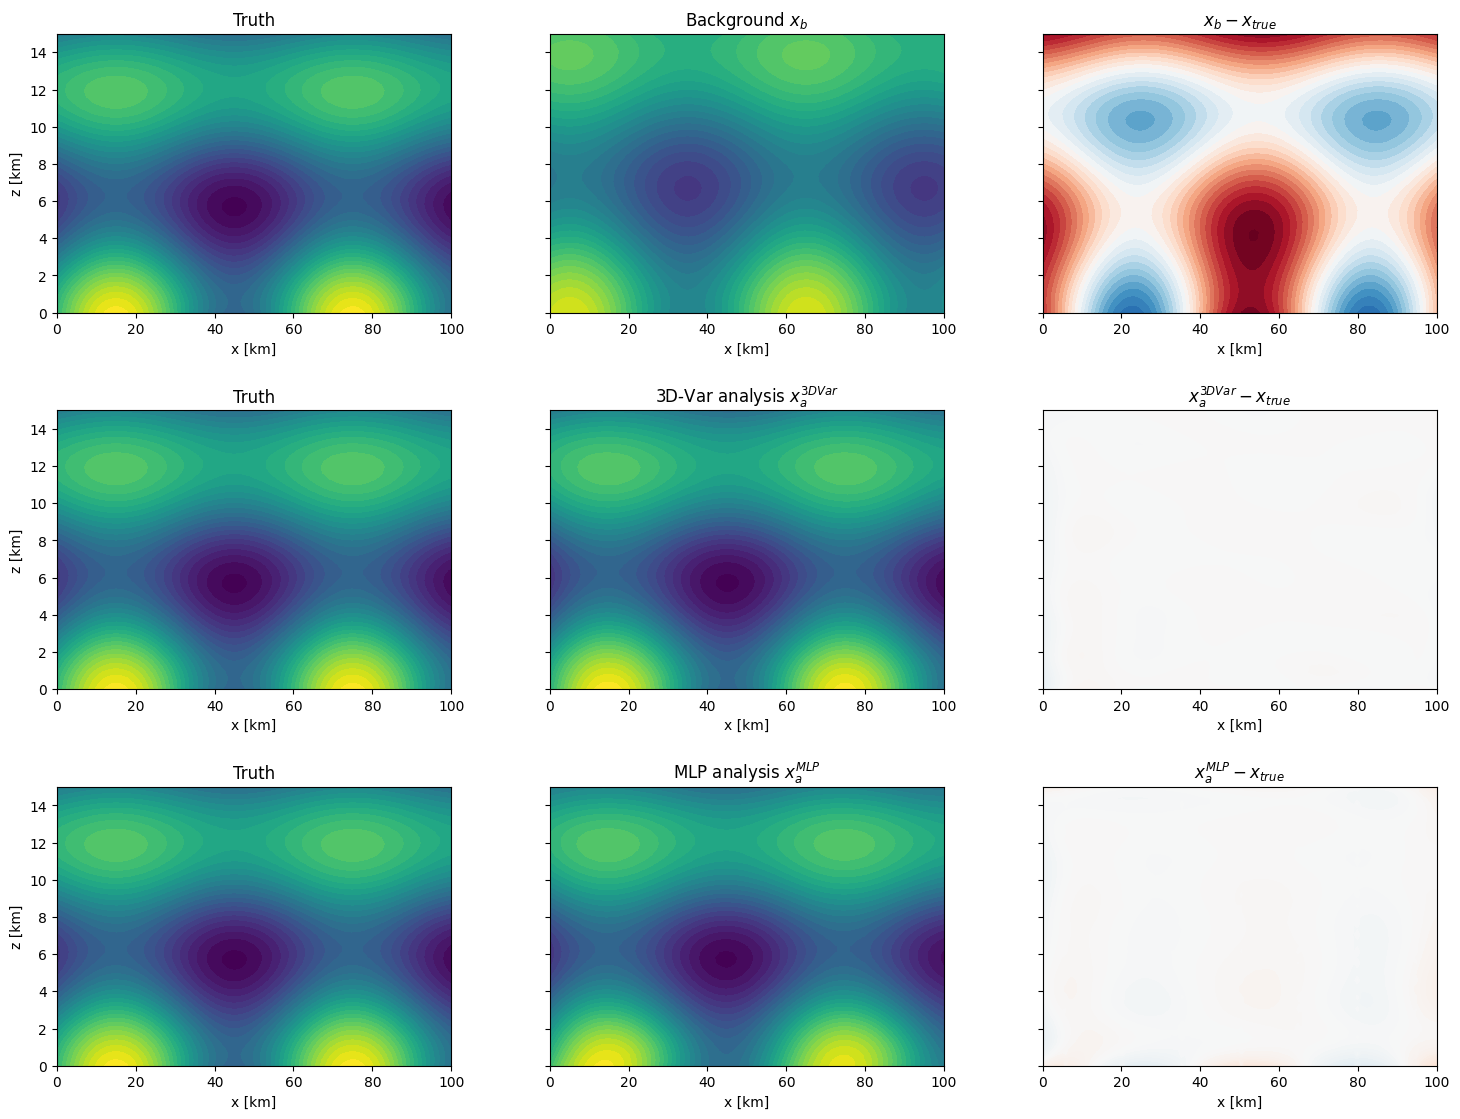


RMSE summary:
 RMSE(xb)       : 8.923e-01
 RMSE(3D-Var)   : 1.713e-02
 RMSE(MLP)      : 3.871e-02


In [18]:
# ============================================================
# Cell 3 (REPLACEMENT, corrected): Compare MLP analysis with 3D-Var
# ============================================================

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import torch

# ------------------------------------------------------------
# Reconstruct analysis from learned increment
# ------------------------------------------------------------
with torch.no_grad():
    delta_x = model(inp_t).cpu().numpy()      # <<< FIXED (was model(xb_t))

xa_mlp = (xb_t.cpu().numpy() + delta_x).reshape(nz, nx)

# ------------------------------------------------------------
# Errors
# ------------------------------------------------------------
err_b   = xb - xtrue
err_3dv = xa_3dvar - xtrue
err_mlp = xa_mlp - xtrue

err_max = max(
    np.abs(err_b).max(),
    np.abs(err_3dv).max(),
    np.abs(err_mlp).max()
)

# ------------------------------------------------------------
# Normalizations
# ------------------------------------------------------------
norm_state = Normalize(
    vmin=min(xtrue.min(), xb.min(), xa_3dvar.min(), xa_mlp.min()),
    vmax=max(xtrue.max(), xb.max(), xa_3dvar.max(), xa_mlp.max())
)
norm_err = Normalize(vmin=-err_max, vmax=err_max)

# ------------------------------------------------------------
# Plot: 3x3 layout (Truth | States | Errors)
# ------------------------------------------------------------
fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharey=True)

# === Column 1: Truth (repeated) ===
for i in range(3):
    axs[i, 0].contourf(X, Z, xtrue, levels=30, cmap="viridis", norm=norm_state)
    axs[i, 0].set_ylabel("z [km]")
    axs[i, 0].set_xlabel("x [km]")
    axs[i, 0].set_title("Truth")

# === Column 2: States ===
axs[0, 1].contourf(X, Z, xb, levels=30, cmap="viridis", norm=norm_state)
axs[0, 1].set_title("Background $x_b$")

axs[1, 1].contourf(X, Z, xa_3dvar, levels=30, cmap="viridis", norm=norm_state)
axs[1, 1].set_title("3D-Var analysis $x_a^{3DVar}$")

axs[2, 1].contourf(X, Z, xa_mlp, levels=30, cmap="viridis", norm=norm_state)
axs[2, 1].set_title("MLP analysis $x_a^{MLP}$")

for i in range(3):
    axs[i, 1].set_xlabel("x [km]")

# === Column 3: Errors ===
axs[0, 2].contourf(X, Z, err_b, levels=30, cmap="RdBu_r", norm=norm_err)
axs[0, 2].set_title(r"$x_b - x_{true}$")

axs[1, 2].contourf(X, Z, err_3dv, levels=30, cmap="RdBu_r", norm=norm_err)
axs[1, 2].set_title(r"$x_a^{3DVar} - x_{true}$")

axs[2, 2].contourf(X, Z, err_mlp, levels=30, cmap="RdBu_r", norm=norm_err)
axs[2, 2].set_title(r"$x_a^{MLP} - x_{true}$")

for i in range(3):
    axs[i, 2].set_xlabel("x [km]")

fig.subplots_adjust(
    left=0.06,
    right=0.98,
    bottom=0.06,
    top=0.92,
    wspace=0.25,
    hspace=0.35
)

plt.savefig("2d_xa_MLP_xa_3dVAR.png")
plt.show()

# ------------------------------------------------------------
# RMSE comparison (grid-point normalized)
# ------------------------------------------------------------
rmse = lambda e: np.sqrt(np.mean(e**2))

print("\nRMSE summary:")
print(f" RMSE(xb)       : {rmse(err_b):.3e}")
print(f" RMSE(3D-Var)   : {rmse(err_3dv):.3e}")
print(f" RMSE(MLP)      : {rmse(err_mlp):.3e}")
